In [657]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import block_diag

plt.close('all')

Loading the data

In [658]:
data = np.load('data_point_land_1.npz', allow_pickle=True)

#print(data.files)

Meas = data['Meas'] #Landmark measurements
Uf = data['Uf'] #measured forward velocity (odometry)
Ua = data['Ua'] #measured angular velocity (odometry)
Q = data['Q']
Qturn = data['Qturn']
R = data['R']
Nland = data['Nland'] #number of Landmarks
Ts = data['Ts']
Wturn = data['wturn'] #treshold Wturn
Pose = data['Pose'] #data to be used only for comparison (x(t), y(t), theta(t) of the robot)
Landmarks = data['Landmarks'] #data to be used only for comparison (ith row corresponds to i+1th of landmark locations.)

In [659]:
print(Pose)

[[ 1.          1.          0.        ]
 [ 1.5         1.          0.        ]
 [ 2.          1.          0.        ]
 [ 2.5         1.          0.        ]
 [ 3.          1.          0.        ]
 [ 3.5         1.          0.        ]
 [ 4.          1.          0.        ]
 [ 4.5         1.          0.        ]
 [ 5.          1.          0.        ]
 [ 5.5         1.          0.        ]
 [ 6.          1.          0.        ]
 [ 6.5         1.          0.        ]
 [ 7.          1.          0.        ]
 [ 7.5         1.          0.        ]
 [ 8.          1.          0.        ]
 [ 8.5         1.          0.        ]
 [ 9.          1.          0.        ]
 [ 9.5         1.          0.        ]
 [10.          1.          0.        ]
 [10.5         1.          0.        ]
 [11.          1.          0.        ]
 [11.5         1.          0.        ]
 [12.          1.          0.        ]
 [12.5         1.          0.        ]
 [13.          1.          0.        ]
 [13.5         1.        

In [660]:
range_land = Meas.item()['range'] #landmark ranges
angle_land = Meas.item()['angle']  #landmark angles
index_land = Meas.item()['land']  #landmark indices

Angle Wrapping Function

In [661]:
def angle_wrap(angle):
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return angle

def innovation(M, xp):
    # x = xp[0]
    # y = xp[1]
    # theta = xp[2]
    landmarks = M[:, 2]

    # take the predictions
    predicted_meas = np.zeros((len(landmarks), 2))
    
    for i in range(len(landmarks)):
        j = int(landmarks[i] - 1)

        lx = xp[n_upper + 2*j]
        ly = xp[n_upper + 2*j + 1]
        
        predicted_p = np.sqrt((lx - xp[0])**2 + (ly - xp[1])**2)
        predicted_alpha = angle_wrap(np.arctan2(ly - xp[1], lx - xp[0]) - xp[2])
        predicted_meas[i][0] = predicted_p
        predicted_meas[i][1] = predicted_alpha
    
    inn = M[:, :2] - predicted_meas
    return inn.reshape(-1,1)

Initialising

In [662]:
N = Uf.shape[0] #Number of odometry measurements

n_upper = 3 #upper system order: x,y,theta
n_lower = Nland.item()*2 #lower system order: 2 for every landmark (x,y)
n = n_upper + n_lower  #system order

x0 = np.zeros(n) #initial states
x0[0] = Pose[0,0] #x(0)
x0[1] = Pose[0,1] #y(0)
x0[2] = Pose[0,2] #theta(0)
#upper covariance
lambda_ = 0.01
P_upper = lambda_ * np.eye(n_upper) #uncertainty of x,y,theta
upper_zeros = np.zeros((n_upper,n_lower))
#lower covariance
eta = 1000000
P_lower = eta * np.eye(n_lower) #uncertainty landmarks
lower_zeros = np.zeros((n_lower,n_upper))
#Initial covariance
P0 = np.block([[P_upper,upper_zeros],
              [lower_zeros,P_lower]])
Xp = x0.copy()
Pp = P0.copy()

In [663]:
print(Q)
print('----------------')
print(Qturn)

[[1.00000000e-02 0.00000000e+00]
 [0.00000000e+00 7.61543549e-05]]
----------------
[[0.01       0.        ]
 [0.         0.06853892]]


EKF loop

In [664]:
Xp = x0.copy()
Pp = P0.copy()
X_pred = np.empty((N,n))
P_pred = np.empty((N,n))
i = 0

Q_straight = Q

checked_landmarks = []
while i < N:
    # Prediction
    Xp_lower = np.zeros(n_lower)
    # isn't it: np.concatenate((Ts*np.array([Uf[i]*np.cos(Xp[2]), Uf[i]*np.sin(Xp[2]), Ua[i]]), Xp_lower))
    # Xp = Xp + np.concatenate((np.array([Uf[i]*np.cos(Xp[2]), Uf[i]*np.cos(Xp[2]), Ua[i]]), Xp_lower))
    Xp = Xp + np.concatenate((Ts*np.array([Uf[i]*np.cos(Xp[2]), Uf[i]*np.sin(Xp[2]), Ua[i]]), Xp_lower))
    Xp[2] = angle_wrap(Xp[2])
    dUpper_dx = np.array([[1, 0, -Ts*Uf[i]*np.sin(Xp[2])],
                          [0, 1, Ts*Uf[i]*np.cos(Xp[2])],
                          [0, 0, 1]])
    dLower_dx = np.eye(n_lower)
    F = np.block([[dUpper_dx,upper_zeros],
                [lower_zeros,dLower_dx]])
    dupper_dw = np.array([[-Ts*np.cos(Xp[2]), 0],
                  [-Ts*np.sin(Xp[2]), 0],
                  [0, -Ts]])
    dlower_dw = np.zeros((n_lower, 2))
    G = np.block([[dupper_dw],
                  [dlower_dw]])

    if Ua[i] > Wturn: #If turn rate is bigger than a given turn rate:
        Q = Qturn
        counter = 0
    else:
        Q = Q_straight

    Pp = F@Pp@F.T + G@Q@G.T


    
    """
        ########### Correction ###########
        
        Find the landmark and correct
        We need two Jacobians
    """

    # x = Xp[0]
    # y = Xp[1]
    # theta = Xp[2]
    old = [] # already initialized, needs to make correction
    new = []


    for l in range(len(index_land[i])):
        if index_land[i][l] in checked_landmarks: # first make it like this in order to build the logic
            old.append(l)
        else:
            checked_landmarks.append(index_land[i][l])
            new.append(l)



    # these arrays will store the measurements for the old(already initialized) positions
    to_be_corrected_range = []
    to_be_corrected_angle = []
    to_be_corrected_index = []
    for m in old:
        to_be_corrected_range.append(range_land[i][m])
        to_be_corrected_angle.append(angle_land[i][m])
        to_be_corrected_index.append(index_land[i][m])

    to_be_init_range = []
    to_be_init_angle = []
    to_be_init_index = []
    for m in new:
        to_be_init_range.append(range_land[i][m])
        to_be_init_angle.append(angle_land[i][m])
        to_be_init_index.append(index_land[i][m])

    for k in range(len(to_be_init_range)):
        j = to_be_init_index[k] - 1 
        mp = to_be_init_range[k]
        ma = to_be_init_angle[k]

        lx = Xp[0] + mp * np.cos(Xp[2] + ma)
        ly = Xp[1] + mp * np.sin(Xp[2] + ma)
        Xp[n_upper + 2*j] = lx  
        Xp[n_upper + 2*j + 1] = ly  
    
    # first make it for checked as they are not checked

    if to_be_corrected_range:
        H = np.zeros((len(to_be_corrected_range)*2, n))
        for k in range(len(to_be_corrected_range)):
            # landmarks are from 1, so when we see landmark 1 it means that it will
            # be on the 0 position after x, y, theta - Lx = 3, Ly = 4
            j = to_be_corrected_index[k] - 1 

            lx = Xp[n_upper + 2*j]
            ly = Xp[n_upper + 2*j + 1]

            row_p = k*2
            row_alpha = k*2 + 1
            # derivatives with respect to m_p
            p_den = np.sqrt((lx - Xp[0])**2 + (ly - Xp[1])**2) 

            H[row_p][0] = (Xp[0] - lx)/p_den # dx
            H[row_p][1] = (Xp[1] - ly)/p_den # dy
            H[row_p][2] = 0 # dtheta
            H[row_p][n_upper + 2*j] = (lx - Xp[0])/p_den #dlx
            H[row_p][n_upper + 2*j+1] = (ly - Xp[1])/p_den #dly


            # derivatives with respect to m_alpha
            alpha_den = (lx - Xp[0])**2 + (ly - Xp[1])**2
            H[row_alpha][0] = (ly - Xp[1])/alpha_den # dx
            H[row_alpha][1] = -(lx - Xp[0])/alpha_den #dy
            H[row_alpha][2] = -1 #dtheta
            H[row_alpha][n_upper + 2*j] = -(ly - Xp[1])/alpha_den #dlx
            H[row_alpha][n_upper + 2*j + 1] = (lx - Xp[0])/alpha_den #dly

        # build R
        R_new = np.kron(np.eye(len(to_be_corrected_range)), R)
        # Equations
        K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R_new)
        P = Pp - K @ H @ Pp
        measurement =  np.array([to_be_corrected_range, to_be_corrected_angle, to_be_corrected_index]).T
        inn = innovation(measurement, Xp)
        
        X = Xp + (K @ inn).reshape(-1)
        X[2] = angle_wrap(X[2])
        Xp = X.copy()
        Pp = P.copy()
    
    # print('------------')
    # print(Xp.shape)
    # print(X_pred.shape)
    # print('------------')
    print(index_land[i])
    X_pred[i, :] = Xp
    for r in range(39):
        if Xp[r] == 0:
            continue
        print(str(r) + ' = ' + str(Xp[r]))
    
    print('-------------------')
    i += 1
    
    # if i == 200:
    #     break



[ 1  2 16]
0 = 1.566579325206476
1 = 1.0
2 = 0.0031209932933848883
3 = 4.545597416078203
4 = 3.997189189814021
5 = 8.569222484998676
6 = 4.010997790023929
33 = 4.571998871075177
34 = 7.998335767066618
-------------------
[ 1  2 16]
0 = 1.9893072555117406
1 = 1.0013193252151986
2 = 0.0030844015079565246
3 = 4.488012138978095
4 = 3.9999185201302736
5 = 8.486865865404742
6 = 3.985711081875208
33 = 4.465340172386652
34 = 8.010723910627323
-------------------
[ 1  2 16]
0 = 2.4838859435658946
1 = 1.0112814908103926
2 = 0.003715251687901766
3 = 4.464467063919209
4 = 4.025564298220789
5 = 8.4772341976992
6 = 4.0249177828467415
33 = 4.429169800563193
34 = 8.028374466287296
-------------------
[ 1  2  3 16]
0 = 2.995874849125186
1 = 0.9993954436275995
2 = -0.001447537701475543
3 = 4.483222248933925
4 = 3.9999165012170343
5 = 8.49862188953677
6 = 3.9748724228232555
7 = 12.493977135731253
8 = 4.009669098708268
33 = 4.480392187902236
34 = 8.002346381534403
-------------------
[ 1  2  3 16]
0 = 3.4

In [665]:
# take the first three colums for every row from X_pred

pose_pred = X_pred[:, :3]
pose_true = Pose

landmark_pred = X_pred[219, 3:]
print(pose_pred.shape)
print(pose_true.shape)
print(landmark_pred.shape)


(220, 3)
(220, 3)
(36,)


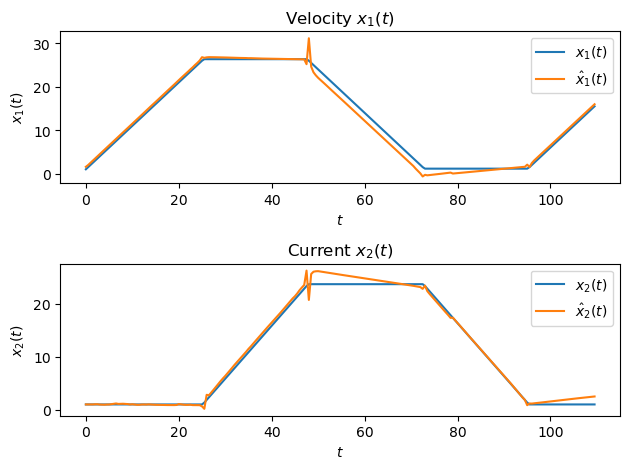

In [666]:
T = np.arange(0,N*Ts, Ts)


fig=plt.figure()
ax1=plt.subplot(2,1,1)
ax1.plot(T,pose_true[:,0],label=r'$x_1(t)$')
ax1.plot(T,pose_pred[:,0],label=r'$\hat{x}_1(t)$')
# ax1.plot(T,xhatinf[:,0],label=r'$\hat{x}^{\infty}_1(t)$')
plt.xlabel("$t$")
plt.ylabel("$x_1(t)$")
plt.title("Velocity $x_1(t)$")
plt.legend()
ax1=plt.subplot(2,1,2)
ax1.plot(T,pose_true[:,1],label=r'$x_2(t)$')
ax1.plot(T,pose_pred[:,1],label=r'$\hat{x}_2(t)$')
# ax1.plot(T,xhatinf[:,1],label=r'$\hat{x}^{\infty}_2(t)$')
plt.xlabel("$t$")
plt.ylabel("$x_2(t)$")
plt.title("Current $x_2(t)$")
plt.legend()
fig.tight_layout()
plt.show()

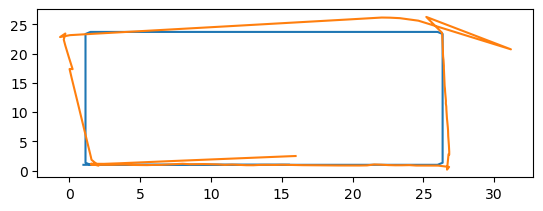

In [667]:
fig = plt.figure()
ax1=plt.subplot(2,1,1)
ax1.plot(pose_true[:,0],pose_true[:,1],label=r'$x_1(t)$')
ax1.plot(pose_pred[:,0],pose_pred[:,1],label=r'$\hat{x}_1(t)$')
plt.show()


In [668]:
print(Landmarks)

[[ 4  4]
 [ 8  4]
 [12  4]
 [16  4]
 [20  4]
 [24  4]
 [24  8]
 [24 12]
 [24 16]
 [ 4 20]
 [ 8 20]
 [12 20]
 [16 20]
 [20 20]
 [24 20]
 [ 4  8]
 [ 4 12]
 [ 4 16]]


In [669]:
print(landmark_pred)
landmark_pred = landmark_pred.reshape(-1,2)
print(landmark_pred)

[ 4.19715474  4.33843644  8.19273708  4.73559205 12.18106433  5.14142409
 16.16758322  5.5392883  20.16174939  5.93230684 24.16918932  6.29279668
 23.75598174 10.30140614 23.36453948 14.29114943 22.98886324 18.28991664
  2.69674126 20.28819094  6.68859805 20.64741392 10.67962032 21.04176084
 14.67120879 21.45928908 18.67322742 21.91570152 22.65053421 22.26800821
  3.83496378  8.32475219  3.46278422 12.3127901   3.08647736 16.30033397]
[[ 4.19715474  4.33843644]
 [ 8.19273708  4.73559205]
 [12.18106433  5.14142409]
 [16.16758322  5.5392883 ]
 [20.16174939  5.93230684]
 [24.16918932  6.29279668]
 [23.75598174 10.30140614]
 [23.36453948 14.29114943]
 [22.98886324 18.28991664]
 [ 2.69674126 20.28819094]
 [ 6.68859805 20.64741392]
 [10.67962032 21.04176084]
 [14.67120879 21.45928908]
 [18.67322742 21.91570152]
 [22.65053421 22.26800821]
 [ 3.83496378  8.32475219]
 [ 3.46278422 12.3127901 ]
 [ 3.08647736 16.30033397]]


(18, 2)


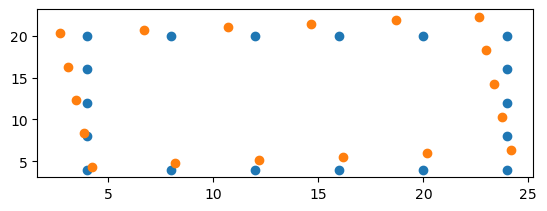

In [670]:
landmark_pred = landmark_pred.reshape(-1,2)
print(landmark_pred.shape)

fig = plt.figure()
ax1=plt.subplot(2,1,1)
ax1.scatter(Landmarks[:,0],Landmarks[:,1],label=r'$x_1(t)$')
ax1.scatter(landmark_pred[:,0],landmark_pred[:,1],label=r'$\hat{x}_1(t)$')
# plt.scatter(x, y)

plt.show()


In [671]:
X

array([15.97517306,  2.50189805,  0.09801937,  4.19715474,  4.33843644,
        8.19273708,  4.73559205, 12.18106433,  5.14142409, 16.16758322,
        5.5392883 , 20.16174939,  5.93230684, 24.16918932,  6.29279668,
       23.75598174, 10.30140614, 23.36453948, 14.29114943, 22.98886324,
       18.28991664,  2.69674126, 20.28819094,  6.68859805, 20.64741392,
       10.67962032, 21.04176084, 14.67120879, 21.45928908, 18.67322742,
       21.91570152, 22.65053421, 22.26800821,  3.83496378,  8.32475219,
        3.46278422, 12.3127901 ,  3.08647736, 16.30033397])

In [672]:
for i in range(45, 55):
    print(range_land[i])
    print(angle_land[i])
    print(index_land[i])
    print('---------------')

[3.04930366 7.0099234 ]
[1.40538025 1.49717024]
[6 7]
---------------
[3.01271821 6.99880447]
[1.56660412 1.57375007]
[6 7]
---------------
[]
[]
[]
---------------
[]
[]
[]
---------------
[]
[]
[]
---------------
[3.61166357 7.27807386]
[1.37157106 1.06223672]
[6 7]
---------------
[6.88206348 3.53100625 7.06890106]
[1.17586314 0.73458289 0.33875085]
[5 6 7]
---------------
[6.70423651 3.1824019  6.59070753]
[1.24848868 0.83249034 0.36966152]
[5 6 7]
---------------
[6.57499678 2.88227893 6.11315297 9.91797036]
[1.31155856 0.95527507 0.39381955 0.23480688]
[5 6 7 8]
---------------
[6.45507474 2.63286155 5.65751375 9.42548396]
[1.39520892 1.11672522 0.42717809 0.25090904]
[5 6 7 8]
---------------


In [673]:
#before correction step: dont forget to insert the landmark into state vector the first time. After inserting don't insert the same one again.
# if landmark
#     L_x[i] = blaba
#     L_y[i] = blabla